# ROC-AUC на кросс-валидации : 0.8156772919375092

# <center> Предсказание победителя в Dota 2
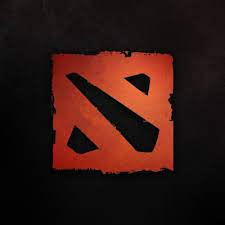

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

In [3]:
import numpy as np

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [4]:
PATH_TO_DATA = "../bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

Wall time: 14.1 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [14]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [15]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-18_11-46-23.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [14]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [12]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

Wall time: 1min 27s


In [13]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [14]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [15]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [17]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [16]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [18]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

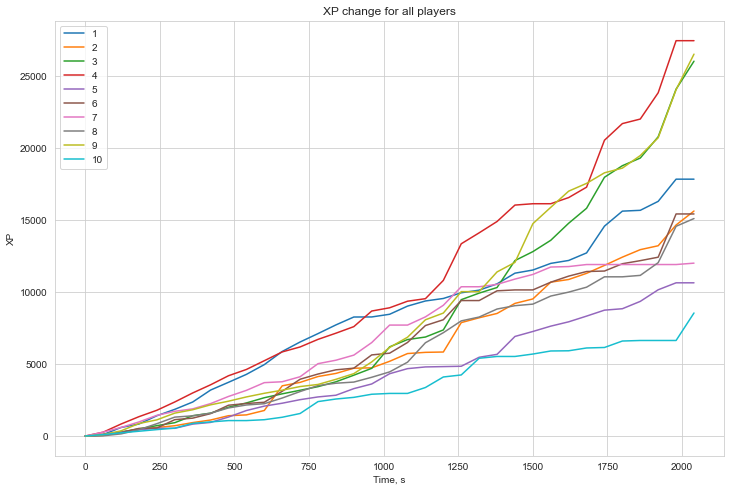

In [19]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [20]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [21]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [22]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [23]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [24]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 2min 37s


In [25]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

### Рубрика ЭЭЭЭЭЭЭЭКСПЕРИМЕНТЫ
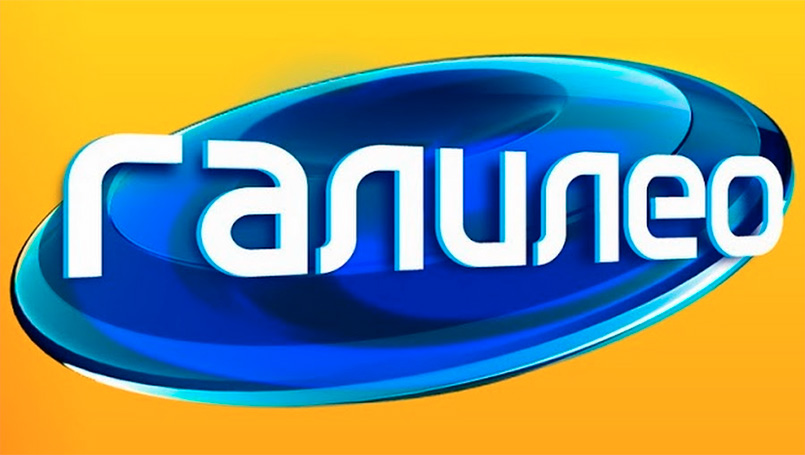

In [23]:
matches = read_matches("train_raw_data.jsonl", total_matches=30, n_matches_to_read=None)

In [24]:
m = [i for i in matches]

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
m[0].keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [18]:
m[0]['players'][0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

#### Получим информацию о доле героев одного из атрибутов в команде (мне подумалось, что если в команде все герои одного атрибута, то может быть дисбаланс)

In [243]:
import requests
from bs4 import BeautifulSoup
import re

In [244]:
reg = re.compile('title=".+">')

In [245]:
resp = requests.get('https://dota2.fandom.com/ru/wiki/%D0%9B%D0%BE%D0%B2%D0%BA%D0%BE%D1%81%D1%82%D1%8C')
soup = BeautifulSoup(resp.content)
a = soup.find_all('td', style="width:75px;")
heroes = list(map(lambda x: re.findall(reg, str(x))[0].split('"')[1].lower(), a))
heroes_a = list(map(lambda x: '_'.join(x.split()), heroes))
# heroes_a

In [246]:
resp = requests.get('https://dota2.fandom.com/ru/wiki/%D0%98%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82')
soup = BeautifulSoup(resp.content)
a = soup.find_all('td', style="width:75px;")
heroes = list(map(lambda x: re.findall(reg, str(x))[0].split('"')[1].lower(), a))
heroes_i = list(map(lambda x: '_'.join(x.split()), heroes))
# heroes_i

In [247]:
resp = requests.get('https://dota2.fandom.com/ru/wiki/%D0%A1%D0%B8%D0%BB%D0%B0')
soup = BeautifulSoup(resp.content)
a = soup.find_all('td', style="width:75px;")
heroes = list(map(lambda x: re.findall(reg, str(x))[0].split('"')[1].lower(), a))
heroes_s = list(map(lambda x: '_'.join(x.split()), heroes))
#heroes_s

In [248]:
strength = ''.join(heroes_s)
agility = ''.join(heroes_a)
intelligence = ''.join(heroes_i)

In [249]:
strenth_list = []
for i in range(len(m)):
    strenth_list.append((len(list(filter(lambda x: x in strength, list(map(lambda x: x['hero_name'].split('_')[-1], m[i]['players']))[:5])))/5,
     len(list(filter(lambda x: x in strength, list(map(lambda x: x['hero_name'].split('_')[-1], m[i]['players']))[5:])))/5))

In [250]:
strenth_list

[(0.2, 0.2),
 (0.2, 0.4),
 (0.4, 0.4),
 (0.4, 0.2),
 (0.4, 0.0),
 (0.6, 0.2),
 (0.4, 0.4),
 (0.6, 0.2),
 (0.0, 0.4),
 (0.2, 0.2),
 (0.2, 0.2),
 (0.0, 0.2),
 (0.2, 0.4),
 (0.6, 0.6),
 (0.4, 0.4),
 (0.0, 0.2),
 (0.4, 0.6),
 (0.0, 0.4),
 (0.2, 0.6),
 (0.2, 0.4),
 (0.4, 0.2),
 (0.2, 0.4),
 (0.0, 0.4),
 (0.4, 0.0),
 (0.6, 0.4),
 (0.4, 0.2),
 (0.4, 0.2),
 (0.6, 0.4),
 (0.4, 0.4),
 (0.4, 0.0)]

In [82]:
agility_list = []
for i in range(len(m)):
    agility_list.append((len(list(filter(lambda x: x in agility, list(map(lambda x: x['hero_name'].split('_')[-1], m[i]['players']))[:5])))/5,
     len(list(filter(lambda x: x in agility, list(map(lambda x: x['hero_name'].split('_')[-1], m[i]['players']))[5:])))/5))

#### Таким образом, мы получили для каждого матча пропорции атрибутов для каждой из сторон, кроме intelligence, потому что после установления соотношений для силы и ловкости, информация о интеллекте избыточно

#### Подсчитаем отношения среднего опыта между командами (сбалансированный рост команды) и отношение максимумов (несбалансированный рост)

In [17]:
import numpy as np

In [220]:
means = list(map(lambda v: np.mean(list(map(lambda x: x['xp'], v['players'][:5])))-np.mean(list(map(lambda x: x['xp'], v['players'][5:]))),m))
maxx = list(map(lambda v: max(list(map(lambda x: x['xp'], v['players'][:5])))-max(list(map(lambda x: x['xp'], v['players'][5:]))),m))
tru = list(map(lambda x: x['targets']['radiant_win'], m))

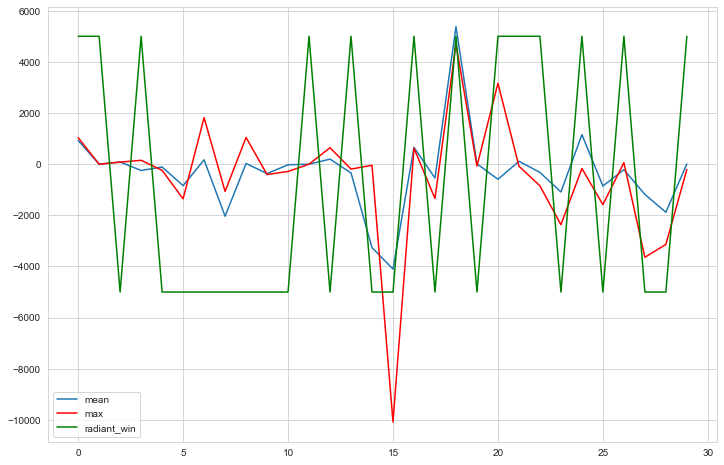

In [221]:
plt.plot(means, label='mean')
plt.plot(maxx,label='max', color='r')
plt.plot(list(map(lambda x: int(x)+5000 if int(x) > 0 else int(x)-5000, tru)), color='g', label='radiant_win')
plt.legend()

##### Может и полезный признак

#### Тоже самое для золота

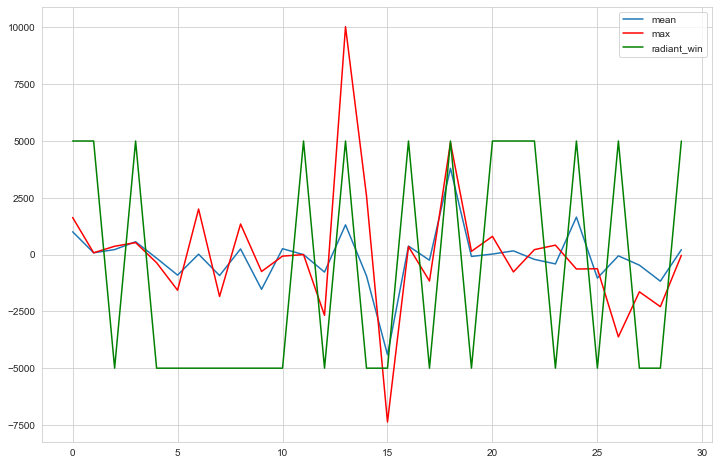

In [108]:
means = list(map(lambda v: np.mean(list(map(lambda x: x['gold'], v['players'][:5])))-np.mean(list(map(lambda x: x['gold'], v['players'][5:]))),m))
maxx = list(map(lambda v: max(list(map(lambda x: x['gold'], v['players'][:5])))-max(list(map(lambda x: x['gold'], v['players'][5:]))),m))
plt.plot(means, label='mean')
plt.plot(maxx,label='max', color='r')
plt.plot(list(map(lambda x: int(x)+5000 if int(x) > 0 else int(x)-5000, tru)), color='g', label='radiant_win')
plt.legend()

##### Пойдет

#### pred_vict; я так понял, этот признак как-то связан с предсказанием выигрыша

In [61]:
radiant_pred = list(map(lambda r: sum(list(map(lambda x: x['pred_vict'], r['players']))[:5]), m))
dir_pred = list(map(lambda r: sum(list(map(lambda x: x['pred_vict'], r['players']))[5:]), m))

In [62]:
diff_preds = list(np.array(radiant_pred)-np.array(dir_pred))

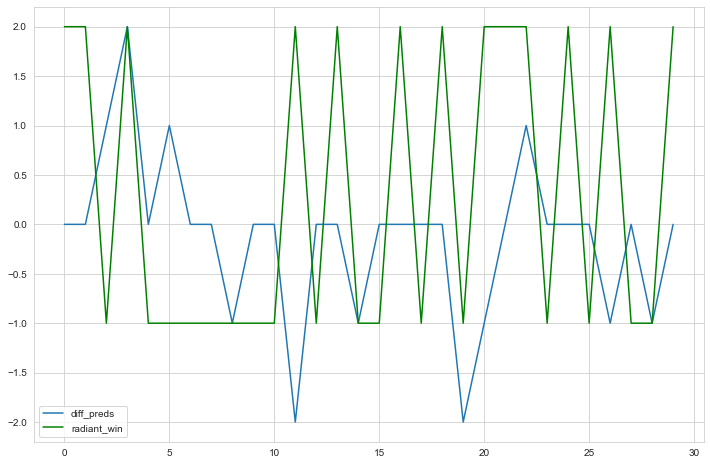

In [65]:
plt.plot(diff_preds, label='diff_preds')
plt.plot(list(map(lambda x: int(x)+1 if int(x) > 0 else int(x)-1, tru)), color='g', label='radiant_win')
plt.legend()

##### Оставим

### Добавим наши признаки в датасет и построим модельку

In [26]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # creeps
        radiant_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][:5])))
        dire_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][5:])))
        diff_creeps = radiant_creeps - dire_creeps
        
        df_features.loc[match_id_hash, "radiant_creeps"] = radiant_creeps
        df_features.loc[match_id_hash, "dire_creeps"] = dire_creeps
        df_features.loc[match_id_hash, "diff_creeps"] = diff_creeps
        
        # dif_mean and max Gold/Exp
        gold_means = np.mean(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        gold_maxx = max(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        
        xp_means = np.mean(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        xp_maxx = max(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        
        df_features.loc[match_id_hash, "diff_gold_means"] = gold_means
        df_features.loc[match_id_hash, "diff_gold_maxx"] = gold_maxx
        df_features.loc[match_id_hash, "diff_xp_means"] = xp_means
        df_features.loc[match_id_hash, "diff_xp_maxx"] = xp_maxx
        
        # pred_vict
        radiant_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][:5])))
        dir_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][5:])))
        diff_preds = radiant_pred-dir_pred
        
        df_features.loc[match_id_hash, "radiant_pred"] = radiant_pred
        df_features.loc[match_id_hash, "dir_pred"] = dir_pred
        df_features.loc[match_id_hash, "diff_preds"] = diff_preds
        
        # strenth and art agility
        radiant_strenth_balance = len(list(filter(lambda x: x in strength, 
                                             list(map(lambda x: x['hero_name'].split('_')[-1], 
                                                      match['players'][:5])))))/5
        
        dire_strenth_balance = len(list(filter(lambda x: x in strength, 
                                             list(map(lambda x: x['hero_name'].split('_')[-1], 
                                                      match['players'][5:])))))/5
        
        radiant_agility_balance = len(list(filter(lambda x: x in agility, 
                                             list(map(lambda x: x['hero_name'].split('_')[-1], 
                                                      match['players'][:5])))))/5
        
        dire_agility_balance = len(list(filter(lambda x: x in agility, 
                                             list(map(lambda x: x['hero_name'].split('_')[-1], 
                                                      match['players'][5:])))))/5
        
        
        df_features.loc[match_id_hash, "radiant_strenth_balance"] = radiant_strenth_balance
        df_features.loc[match_id_hash, "dire_strenth_balance"] = dire_strenth_balance
        df_features.loc[match_id_hash, "radiant_agility_balance"] = radiant_agility_balance
        df_features.loc[match_id_hash, "dire_agility_balance"] = dire_agility_balance
        

In [27]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [28]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_gold_maxx,diff_xp_means,diff_xp_maxx,radiant_pred,dir_pred,diff_preds,radiant_strenth_balance,dire_strenth_balance,radiant_agility_balance,dire_agility_balance
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1633.0,928.2,1041.0,0.0,0.0,0.0,0.2,0.2,0.6,0.2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.4,0.8
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,367.0,85.8,81.0,1.0,0.0,1.0,0.4,0.4,0.2,0.4
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,529.0,-245.0,152.0,2.0,0.0,2.0,0.4,0.2,0.4,0.2
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-358.0,-110.8,-239.0,1.0,1.0,0.0,0.4,0.0,0.4,0.4


In [66]:
df_train_features_extended.to_csv('df_extended.csv') 


#### Сделаем импорт 

In [161]:
df_extended = pd.read_csv('df_extended.csv', index_col="match_id_hash")

In [30]:
df_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_gold_maxx,diff_xp_means,diff_xp_maxx,radiant_pred,dir_pred,diff_preds,radiant_strenth_balance,dire_strenth_balance,radiant_agility_balance,dire_agility_balance
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1633.0,928.2,1041.0,0.0,0.0,0.0,0.2,0.2,0.6,0.2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.4,0.8
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,367.0,85.8,81.0,1.0,0.0,1.0,0.4,0.4,0.2,0.4
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,529.0,-245.0,152.0,2.0,0.0,2.0,0.4,0.2,0.4,0.2
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-358.0,-110.8,-239.0,1.0,1.0,0.0,0.4,0.0,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,-4879.0,-2027.2,-1667.0,1.0,0.0,1.0,0.2,0.6,0.6,0.4
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,3810.0,3743.4,4620.0,0.0,0.0,0.0,0.2,0.4,0.6,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,-1502.0,-871.8,467.0,0.0,0.0,0.0,0.4,0.2,0.8,0.2


In [32]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 2min 37s


In [33]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.8125428107978223


#### Выберем опции RandomForest

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
%%time
rf_model = RandomForestClassifier(random_state=SEED)
params = {'n_estimators': [500, 700], 'max_depth': range(5, 10)}
cv_model = GridSearchCV(rf_model, params, n_jobs=-1, scoring="roc_auc", cv=cv)
cv_model.fit(df_extended.values, y)
cv_model.best_estimator_

Wall time: 30min 51s


RandomForestClassifier(max_depth=9, n_estimators=700, random_state=10801)

In [37]:
%%time
rf_model_v1 = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores_extended_v1 = cross_val_score(rf_model_v1, df_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_v1.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.8125428107978223
ROC-AUC на кросс-валидации для новых признаков: 0.8139416618282963
Wall time: 4min 36s


#### Скор вырос но очень мало, попробуем бустинг

In [38]:
import xgboost

In [39]:
%%time
xgb = xgboost.XGBClassifier(random_state=SEED)
cv_xgb = cross_val_score(xgb, df_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 2min 42s


In [40]:
print(f"ROC-AUC на кросс-валидации для новых признаков для лучшего леса: {cv_scores_extended_v1.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков xgboost: {cv_xgb.mean()}")

ROC-AUC на кросс-валидации для новых признаков для лучшего леса: 0.8139416618282963
ROC-AUC на кросс-валидации для новых признаков xgboost: 0.8004681634540315


#### С нашими параметрами бустинг немного проигрывает, попробуем поставить параметры от RandomForest (gbtree) и чуть уменьшим скорость обучения

In [41]:
%%time
xgb_v2 = xgboost.XGBClassifier(learning_rate=0.1, n_estimators = 700, max_depth = 9, random_state=SEED)
cv_xgb_2 = cross_val_score(xgb_v2, df_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков для лучшего леса: {cv_scores_extended_v1.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков xgboost: {cv_xgb.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков xgboost_v2: {cv_xgb_2.mean()}")

ROC-AUC на кросс-валидации для новых признаков для лучшего леса: 0.8139416618282963
ROC-AUC на кросс-валидации для новых признаков xgboost: 0.8004681634540315
ROC-AUC на кросс-валидации для новых признаков xgboost_v2: 0.8130905164593443
Wall time: 27min 21s


#### Не умею я бустинг использовать -_-

### В этом разделе я хочу оставить интересный неудачный дубль

#### Посмотрим, есть ли в команде "имбовые" комбинации героев, перечисленные вот тут:
https://cybersport.metaratings.ru/guides/luchshie-svyazki-iz-dvukh-geroev-v-dota-2/

Двойные

- Свен + Магнус   magnus, "sven"
- Феникс + Трент  phoenix, treant
- Гримстрок + Дум grimstroke, doom
- Шторм + Чен storm, chen

Тройные

- Бруда - Тинкер - Спирит Брейкер broodmother tinker breaker
- Лина - Лион - Урса lina lion ursa
- Тини - Мирана - Шейкер tiny mirana shaker
- Рики - Лешрак - Винга riki leshrac vengeful
- Слардар - Даззл - Шадов Финд slardar dazzle fiend
- Войд - Инвокер - Веномансер faceless invoker venomancer
- Дум - Бэйн - Некрофус  doom bane necrophos
- Аппарат - Зевс - Фурион apparition zeus prophet
- Шэдов Шаман - Лон Друид - Сайленсер shaman druid silencer 
- Снайпер - Лина - Некрофос sniper lina necrophos 
- Свен - Варлок - Энигма sven warloc enigma
- Шэдов Шаман - Лич - Морфлинг shaman lich morphling

Этими функциями я проверял, правильно ли эти имена у меня в списках записаны

In [251]:
def is_in_atr(name):
    return ("strenth", name in strength, "agility", name in agility, "intelligence", name in intelligence)

In [252]:
is_in_atr("morphling")

('strenth', False, 'agility', True, 'intelligence', False)

В доте есть повторяющиеся имена, обойдем это ограничение

In [253]:
def dota_names(list_name):
    if 'spirit' in list_name:
        if list_name[-1] == 'spirit':
            return list_name[-2]
        else:
            return list_name[-1]
    elif 'king' in list_name:
        return list_name[-2]
    elif 'assassin'in list_name:
        return list_name[-2]
    elif 'knight'in list_name:
        return list_name[-2]
    elif 'prophet'in list_name:
        return list_name[-2]
    else:
        return list_name[-1]

In [254]:
imb_1 = ["magnus", "sven"]
imb_2 = ['phoenix', 'treant']
imb_3 = ['grimstroke', 'doom']
imb_4 = ['storm', 'chen']
imb_5 = ['broodmother', 'tinker', 'breaker']
imb_6 = ['lina', 'lion', 'ursa']
imb_7 = ['tiny', 'mirana', 'shaker']
imb_8 = ['riki', 'leshrac', 'vengeful']
imb_9 = ['slardar', 'dazzle', 'fiend']
imb_10 = ['faceless', 'invoker', 'venomancer']
imb_11 = ['doom', 'bane', 'necrophos']
imb_12 = ['apparition', 'zeus', 'prophet']
imb_13 = ['shaman', 'druid', 'silencer']
imb_14 = ['sniper', 'lina', 'necrophos']
imb_15 = ['sven', 'warloc', 'enigma']
imb_16 = ['shaman', 'lich', 'morphling']

In [255]:
dota_names(m[1]['players'][9]['hero_name'].split('_')[-2:]) in imb_4

True

In [256]:
def counter(x):
    i_1 = int(x in imb_1)
    i_2 = int(x in imb_2)
    i_3 = int(x in imb_3)
    i_4 = int(x in imb_4)
    i_5 = int(x in imb_5)
    i_6 = int(x in imb_6)
    i_7 = int(x in imb_7)
    i_8 = int(x in imb_8)
    i_9 = int(x in imb_9)
    i_10 = int(x in imb_10)
    i_11 = int(x in imb_11)
    i_12 = int(x in imb_12)
    i_13 = int(x in imb_13)
    i_14 = int(x in imb_14)
    i_15 = int(x in imb_15)
    i_16 = int(x in imb_16)
    return i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15, i_16

In [257]:
counter(dota_names(m[1]['players'][9]['hero_name'].split('_')[-2:]))

(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [258]:
i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15, i_16 = [i*0 for i in range(16)]

In [259]:
list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), m[1]['players']))

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

In [260]:
converg_r = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), m[1]['players']))[:5]), axis=0)
converg_d = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), m[1]['players']))[5:]), axis=0)

Тут мы смотрим, надралась ли пара или тройка

In [261]:
sum(list(map(int, converg_d[:4] > 2)) + list(map(int, converg_d[4:] > 3)))

0

##### Запишем наши имбовые комбинации в новый датафрейм и перепишем немного баланс (была ошибка)

In [185]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # creeps
        radiant_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][:5])))
        dire_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][5:])))
        diff_creeps = radiant_creeps - dire_creeps
        
        df_features.loc[match_id_hash, "radiant_creeps"] = radiant_creeps
        df_features.loc[match_id_hash, "dire_creeps"] = dire_creeps
        df_features.loc[match_id_hash, "diff_creeps"] = diff_creeps
        
        # dif_mean and max Gold/Exp
        gold_means = np.mean(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        gold_maxx = max(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        
        xp_means = np.mean(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        xp_maxx = max(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        
        df_features.loc[match_id_hash, "diff_gold_means"] = gold_means
        df_features.loc[match_id_hash, "diff_gold_maxx"] = gold_maxx
        df_features.loc[match_id_hash, "diff_xp_means"] = xp_means
        df_features.loc[match_id_hash, "diff_xp_maxx"] = xp_maxx
        
        # et cho
        radiant_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][:5])))
        dir_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][5:])))
        diff_preds = radiant_pred-dir_pred
        
        df_features.loc[match_id_hash, "radiant_pred"] = radiant_pred
        df_features.loc[match_id_hash, "dir_pred"] = dir_pred
        df_features.loc[match_id_hash, "diff_preds"] = diff_preds
        
        # strenth and agility balance
        
        radiant_strenth_balance = len(list(filter(lambda x: x in strength,
                                                  list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][:5])))))/5
        
        dire_strenth_balance = len(list(filter(lambda x: x in strength,
                                               list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][5:])))))/5
        
        radiant_agility_balance = len(list(filter(lambda x: x in agility,
                                                  list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][:5])))))/5
        
        dire_agility_balance = len(list(filter(lambda x: x in agility,
                                               list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][5:])))))/5
        
        df_features.loc[match_id_hash, "radiant_strenth_balance"] = radiant_strenth_balance
        df_features.loc[match_id_hash, "dire_strenth_balance"] = dire_strenth_balance
        df_features.loc[match_id_hash, "radiant_agility_balance"] = radiant_agility_balance
        df_features.loc[match_id_hash, "dire_agility_balance"] = dire_agility_balance
        
        # sum_imb_combs
        converg_r = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), 
                                             match['players']))[:5]), axis=0)
        converg_d = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), 
                                             match['players']))[5:]), axis=0)
        
        df_features.loc[match_id_hash, "r_sum_imb_combs"] = sum(list(map(int, converg_r[:4] > 2)) + list(map(int, converg_r[4:] > 3)))
        df_features.loc[match_id_hash, "d_sum_imb_combs"] = sum(list(map(int, converg_d[:4] > 2)) + list(map(int, converg_d[4:] > 3)))

In [ ]:
# Код для удачных комбинаций
#         converg_r = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), 
#                                              match['players']))[:5]), axis=0)
#         converg_d = np.sum(np.array(list(map(lambda x: counter(dota_names(x['hero_name'].split('_')[-2:])), 
#                                              match['players']))[5:]), axis=0)
        
#         df_features.loc[match_id_hash, "r_imb_comb_1"], 
#         df_features.loc[match_id_hash, "r_imb_comb_2"],
#         df_features.loc[match_id_hash, "r_imb_comb_3"], 
#         df_features.loc[match_id_hash, "r_imb_comb_4"] = list(map(int, converg_r[:4] > 2))
        
#         df_features.loc[match_id_hash, "d_imb_comb_1"], 
#         df_features.loc[match_id_hash, "d_imb_comb_2"],
#         df_features.loc[match_id_hash, "d_imb_comb_3"], 
#         df_features.loc[match_id_hash, "d_imb_comb_4"] = list(map(int, converg_d[:4] > 2))
        
#         df_features.loc[match_id_hash, "r_imb_comb_5"],
#         df_features.loc[match_id_hash, "r_imb_comb_6"],
#         df_features.loc[match_id_hash, "r_imb_comb_7"],
#         df_features.loc[match_id_hash, "r_imb_comb_8"],
#         df_features.loc[match_id_hash, "r_imb_comb_9"],
#         df_features.loc[match_id_hash, "r_imb_comb_10"],
#         df_features.loc[match_id_hash, "r_imb_comb_11"],
#         df_features.loc[match_id_hash, "r_imb_comb_12"],
#         df_features.loc[match_id_hash, "r_imb_comb_13"],
#         df_features.loc[match_id_hash, "r_imb_comb_14"],
#         df_features.loc[match_id_hash, "r_imb_comb_15"],
#         df_features.loc[match_id_hash, "r_imb_comb_16"] = list(map(int, converg_r[4:] > 3))
        
#         df_features.loc[match_id_hash, "d_imb_comb_5"],
#         df_features.loc[match_id_hash, "d_imb_comb_6"],
#         df_features.loc[match_id_hash, "d_imb_comb_7"],
#         df_features.loc[match_id_hash, "d_imb_comb_8"],
#         df_features.loc[match_id_hash, "d_imb_comb_9"],
#         df_features.loc[match_id_hash, "d_imb_comb_10"],
#         df_features.loc[match_id_hash, "d_imb_comb_11"],
#         df_features.loc[match_id_hash, "d_imb_comb_12"],
#         df_features.loc[match_id_hash, "d_imb_comb_13"],
#         df_features.loc[match_id_hash, "d_imb_comb_14"],
#         df_features.loc[match_id_hash, "d_imb_comb_15"],
#         df_features.loc[match_id_hash, "d_imb_comb_16"] = list(map(int, converg_d[4:] > 3))

In [186]:
# Скопируем таблицу с признаками
df_extended_v3 = df_train_features.copy()

# Добавим новые
add_new_features(df_extended_v3, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [191]:
df_extended_v3["d_sum_imb_combs"].unique(), df_extended_v3["r_sum_imb_combs"].unique()

(array([0.]), array([0.]))

##### Это оооооочень секретные комбинации, такие секретные, что их никто не использует
Ладно, проверим хоть, изменился ли баланс

In [193]:
df_fix = df_extended_v3.drop(["d_sum_imb_combs", "r_sum_imb_combs"], axis=1)

In [194]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_fix.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8125309752637838
Wall time: 1min 43s


##### по-лучше стало чууууть-чуть

In [195]:
df_fix.to_csv('df_extended_v3.csv') 

#### Добавим еще новых признаков

#### фичи, которые уже есть

In [20]:
df.iloc[:,:24].columns

Index(['r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health',
       'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns',
       'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups',
       'r1_firstblood_claimed', 'r1_teamfight_participation',
       'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed',
       'r1_sen_placed'],
      dtype='object')

#### То, что можно добавить

##### nearby_creep_death_count, kda по всем игрокам, 'gold_reasons',
 ##### 'xp_reasons', 'item_uses', 'ability_uses'

#### Посчитаем KDA

In [102]:
def get_kda(death:int, kills:int, assist:int):
    if death:
        kda = (kills+assist)/death
    else:
        kda = kills+assist
    return kda

In [97]:
radiant_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), m[0]["players"]))[:5]
dire_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), m[0]["players"]))[5:]

In [98]:
radiant_kda 

[3.5, 5.0, 5.0, 7, 6]

#### Теперь другие штуки

In [31]:
list(map(lambda x: sum(x['ability_uses'].values()), m[0]['players'])) # на каждого игрока сколько способностей использовал игрок

[9, 21, 11, 35, 18, 11, 45, 22, 17, 7]

In [35]:
list(map(lambda x: sum(x['item_uses'].values()), m[0]['players'])) # item для игроков

[34, 22, 19, 16, 12, 8, 14, 21, 15, 9]

In [37]:
list(map(lambda x: x['nearby_creep_death_count'], m[0]['players'])) # nearby_creep_death_count

[79, 66, 61, 102, 94, 63, 50, 60, 55, 27]

In [62]:
list(map(lambda x: np.std(list(x['gold_reasons'].values())), m[0]['players'])) #  стандартное отклонение признака gold_reasons

[854.5181878306239,
 418.6562312924531,
 322.4297752999869,
 496.7325110157377,
 144.77655196888756,
 363.01316168364417,
 412.95910478184425,
 532.0831606017224,
 445.44431750781155,
 395.8962490350218]

In [63]:
list(map(lambda x: np.std(list(x['gold_reasons'].values())), m[0]['players'])) # среднее gold_reasons

[854.5181878306239,
 418.6562312924531,
 322.4297752999869,
 496.7325110157377,
 144.77655196888756,
 363.01316168364417,
 412.95910478184425,
 532.0831606017224,
 445.44431750781155,
 395.8962490350218]

In [64]:
list(map(lambda x: np.std(list(x['xp_reasons'].values())), m[0]['players'])) # sd xp_reasons

[1187.5,
 1348.5,
 417.87903619216036,
 1518.2064710996622,
 972.7302926413993,
 1258.5,
 1055.7452344197438,
 717.0,
 990.0070706818209,
 497.5]

In [65]:
list(map(lambda x: np.std(list(x['xp_reasons'].values())), m[0]['players'])) # среднее xp_reasons

[1187.5,
 1348.5,
 417.87903619216036,
 1518.2064710996622,
 972.7302926413993,
 1258.5,
 1055.7452344197438,
 717.0,
 990.0070706818209,
 497.5]

#### Загрузим датасет

In [185]:
data_v3 = pd.read_csv("df_extended_v3.csv", index_col="match_id_hash")
data_v3

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_gold_maxx,diff_xp_means,diff_xp_maxx,radiant_pred,dir_pred,diff_preds,radiant_strenth_balance,dire_strenth_balance,radiant_agility_balance,dire_agility_balance
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1633.0,928.2,1041.0,0.0,0.0,0.0,0.2,0.2,0.6,0.2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.4,0.6
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,367.0,85.8,81.0,1.0,0.0,1.0,0.4,0.4,0.2,0.4
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,529.0,-245.0,152.0,2.0,0.0,2.0,0.4,0.2,0.4,0.2
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-358.0,-110.8,-239.0,1.0,1.0,0.0,0.2,0.0,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,-4879.0,-2027.2,-1667.0,1.0,0.0,1.0,0.2,0.4,0.6,0.2
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,3810.0,3743.4,4620.0,0.0,0.0,0.0,0.0,0.4,0.4,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,-1502.0,-871.8,467.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2


#### Добавим еще фичей

In [126]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
      
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # KDA                                           
        radiant_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), match["players"]))[:5]
        dire_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), match["players"]))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_kda'] = radiant_kda[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_kda'] = dire_kda[i]
            
        # ability_uses для игроков
        
        radiant_ability = list(map(lambda x: sum(x['ability_uses'].values()), match['players']))[:5]
        dire_ability = list(map(lambda x: sum(x['ability_uses'].values()), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_ability_uses'] = radiant_ability[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_ability_uses'] = dire_ability[i]
        
        # item для игроков
        
        radiant_item = list(map(lambda x: sum(x['item_uses'].values()), match['players']))[:5]
        dire_item = list(map(lambda x: sum(x['item_uses'].values()), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_item_uses'] = radiant_item[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_item_uses'] = dire_item[i]
            
        # nearby_creep_death_count
        radiant_creeps = list(map(lambda x: x['nearby_creep_death_count'], match['players']))[:5]
        dire_creeps = list(map(lambda x: x['nearby_creep_death_count'], match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_creep_count'] = radiant_creeps[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_creep_count'] = dire_creeps[i]
        
        #  стандартное отклонение признака gold_reasons
        rad_gold = list(map(lambda x: np.std(list(x['gold_reasons'].values())), match['players']))[:5]
        dire_gold = list(map(lambda x: np.std(list(x['gold_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_sd_gold_reasons'] = rad_gold[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_sd_gold_reasons'] = dire_gold[i]
            
        # среднее признака gold_reasons
        rad_gold = list(map(lambda x: np.mean(list(x['gold_reasons'].values())), match['players']))[:5]
        dire_gold = list(map(lambda x: np.mean(list(x['gold_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_mean_gold_reasons'] = rad_gold[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_mean_gold_reasons'] = dire_gold[i]
        
        #  стандартное отклонение признака xp_reasons
        rad_xp = list(map(lambda x: np.std(list(x['xp_reasons'].values())), match['players']))[:5]
        dire_xp = list(map(lambda x: np.std(list(x['xp_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_sd_xp_reasons'] = rad_xp[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_sd_xp_reasons'] = dire_xp[i]
            
        # среднее признака xp_reasons
        rad_xp = list(map(lambda x: np.mean(list(x['xp_reasons'].values())), match['players']))[:5]
        dire_xp = list(map(lambda x: np.mean(list(x['xp_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_mean_xp_reasons'] = rad_xp[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_mean_xp_reasons'] = dire_xp[i]


In [187]:
df = data_v3.copy()
# Добавим новые
add_new_features(df, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [188]:
df.isna().sum()

game_time                0
game_mode                0
lobby_type               0
objectives_len           0
chat_len                 0
                      ... 
d_3_mean_xp_reasons    568
r_4_mean_xp_reasons    571
d_4_mean_xp_reasons    590
r_5_mean_xp_reasons    565
d_5_mean_xp_reasons    597
Length: 342, dtype: int64

Тут получилось кое-где NaN, но таких наблюдений относительно мало, просто на 0 заменим

In [189]:
df_fix = df.fillna(0)

In [190]:
df_fix.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_1_mean_xp_reasons,d_1_mean_xp_reasons,r_2_mean_xp_reasons,d_2_mean_xp_reasons,r_3_mean_xp_reasons,d_3_mean_xp_reasons,r_4_mean_xp_reasons,d_4_mean_xp_reasons,r_5_mean_xp_reasons,d_5_mean_xp_reasons
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1968.500000,1640.500000,1948.500000,787.0,854.333333,1709.000000,1487.333333,910.0,904.666667,568.500000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,359.000000,326.000000,1045.000000,383.0,833.000000,964.000000,387.000000,565.0,318.000000,275.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,1414.000000,2242.666667,1615.500000,3764.0,3417.500000,1904.000000,3840.000000,2822.5,1847.333333,1816.000000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1321.666667,344.666667,747.333333,2061.5,1440.000000,1401.666667,782.000000,1163.0,1618.000000,251.666667


In [191]:
%%time
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores = cross_val_score(rf_model, df_fix.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.8143291476168903
Wall time: 5min 54s


## Обработка фичей

In [192]:
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder)

<AxesSubplot:>

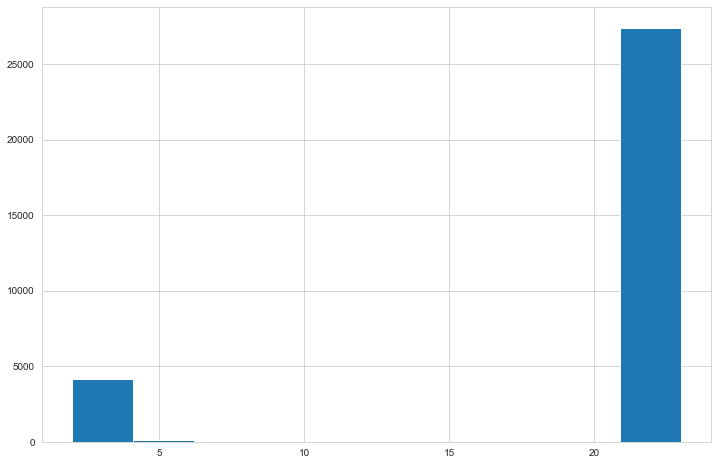

In [225]:
df_fix.game_mode.hist()

In [230]:
df_fix.game_mode.unique()

array([ 4, 23, 22,  3,  2,  5, 16, 12], dtype=int64)

<AxesSubplot:>

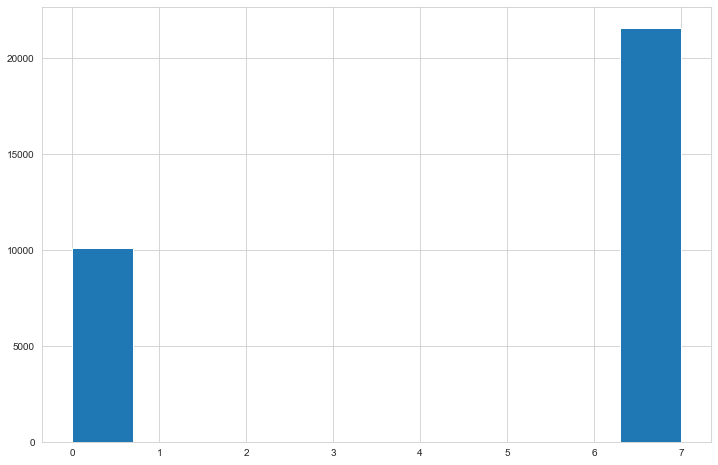

In [226]:
df_fix.lobby_type.hist()

In [231]:
df_fix.lobby_type.unique()

array([0, 7], dtype=int64)

#### Тип лобби точно лейблом сделаем, а режим игры лучше OHE

In [208]:
le = LabelEncoder()
lobby_type = le.fit_transform(df_fix[["lobby_type"]])
ohe = OneHotEncoder()
game_mode = ohe.fit_transform(df_fix[["game_mode"]])

In [209]:
df_fix_2 = df_fix.drop(["lobby_type", "objectives_len", "game_mode"], axis=1)

In [210]:
df_fix_2["lobby_type"] = lobby_type
game_mode = game_mode.toarray()
for i in range(game_mode.shape[1]):
    df_fix_2["game_mode_"+str(i+1)] = game_mode[:,i]

In [211]:
%%time
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores = cross_val_score(rf_model, df_fix_2.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.8144714111008863
Wall time: 6min 34s


Неплохо

#### Проведем селекцию фичей

In [282]:
X = df_fix_2.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [283]:
feat_labels = df_fix_2.columns
forest = RandomForestClassifier(n_estimators=700, max_depth=9, n_jobs=-1, random_state=SEED) 
forest.fit(X_train, y_train) 
importances = forest.feature_importances_ 
indices = np.argsort(importances)[::-1]

In [284]:
for f in range(X_train.shape[1]): 
    print("%2d) %-*s %f" % (f+1,30,
                          feat_labels[indices[f]], 
                          importances[indices[f]]))

 1) diff_gold_means                0.107746
 2) diff_xp_means                  0.095518
 3) diff_gold_maxx                 0.060027
 4) diff_tower_kills               0.049440
 5) diff_creeps                    0.042683
 6) diff_xp_maxx                   0.036259
 7) dire_tower_kills               0.015006
 8) d_4_kda                        0.013995
 9) radiant_tower_kills            0.013649
10) d_5_kda                        0.012268
11) d_3_kda                        0.011824
12) r_4_kda                        0.011589
13) r_1_kda                        0.011373
14) r_3_kda                        0.010230
15) d_1_kda                        0.010162
16) d_2_kda                        0.010085
17) r_2_kda                        0.010049
18) r_5_kda                        0.008618
19) r2_y                           0.008134
20) d2_y                           0.007060
21) r5_x                           0.007045
22) r3_y                           0.006471
23) r1_y                        

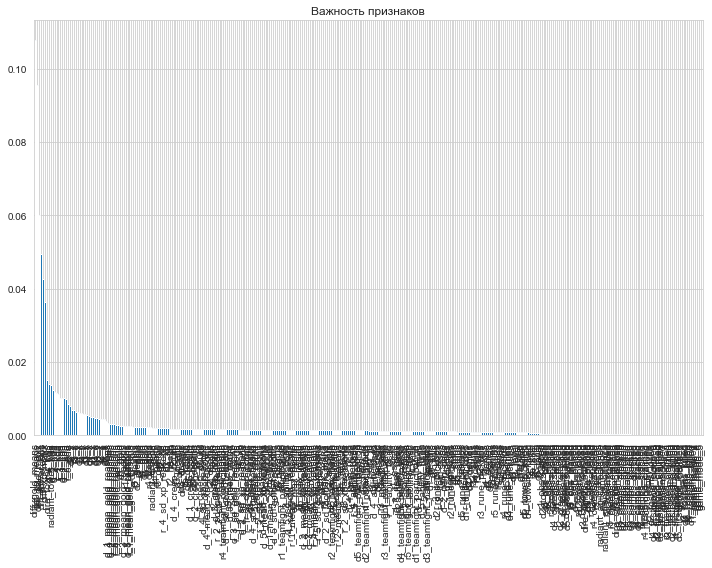

In [285]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Важность признаков') 
plt.bar(range(X_train.shape[1]), 
        importances[indices], 
        align='center') 
plt.xticks(range(X_train.shape[1]), 
                 feat_labels[indices], 
                 rotation=90) 
plt.xlim([-1, X_train.shape[1]]) 
plt.tight_layout() 
plt.show()

#### Построим модель на первых 200 признаках

In [218]:
data_red = df_fix[feat_labels[indices[:200]].values]
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores = cross_val_score(rf_model, data_red.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.8148032346291298


#### На первых 100 признаках

In [219]:
data_red = df_fix[feat_labels[indices[:100]].values]
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores = cross_val_score(rf_model, data_red.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.815600187872396


#### На первых 50 признаках

In [222]:
data_red = df_fix[feat_labels[indices[:50]].values]
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, random_state=SEED)
cv_scores = cross_val_score(rf_model, data_red.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.8153337877808144


#### Оставим 100 признаков и возьмем улучшенную модель

In [224]:
data_red = df_fix[feat_labels[indices[:100]].values]
rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 10, random_state=SEED)
cv_scores = cross_val_score(rf_model, data_red.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для улучшеного леса и id: {cv_scores.mean()}")

ROC-AUC на кросс-валидации для улучшеного леса и id: 0.8156772919375092


In [232]:
data_red.to_csv("data_5.csv")

### Я не успел сюда залить то, как я отбирал модели (это был другой ноутбук, с GoogleColab, потому что так ресурсы компьютера не задействуются, а он у меня слабый). Я прикреплю в репозиторий дополнительно и ноутбук с колаба (Additional_Dota), там я пробовал по-разному переменные трансформировать и модели отбирать. Если кратко, то лучше всего себя показал Random Forest с параметрами n_estimators = 700, max_depth = 10 (я их немного подбирал, да и селекцию фичей по RF проводил, поэтому это не совсем честно, но тем не менее, это лучшее, что у меня получилось)

#### Это максимум, который у меня получился. Его и отправим

In [240]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")

In [262]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # creeps
        radiant_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][:5])))
        dire_creeps = sum(list(map(lambda x: x['nearby_creep_death_count'], match['players'][5:])))
        diff_creeps = radiant_creeps - dire_creeps
        
        df_features.loc[match_id_hash, "radiant_creeps"] = radiant_creeps
        df_features.loc[match_id_hash, "dire_creeps"] = dire_creeps
        df_features.loc[match_id_hash, "diff_creeps"] = diff_creeps
        
        # dif_mean and max Gold/Exp
        gold_means = np.mean(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        gold_maxx = max(list(map(lambda x: x['gold'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['gold'], 
                                                                                         match['players'][5:])))
        
        xp_means = np.mean(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-np.mean(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        xp_maxx = max(list(map(lambda x: x['xp'], 
                                                    match['players'][:5])))-max(list(map(lambda x: x['xp'], 
                                                                                         match['players'][5:])))
        
        df_features.loc[match_id_hash, "diff_gold_means"] = gold_means
        df_features.loc[match_id_hash, "diff_gold_maxx"] = gold_maxx
        df_features.loc[match_id_hash, "diff_xp_means"] = xp_means
        df_features.loc[match_id_hash, "diff_xp_maxx"] = xp_maxx
        
        # et cho
        radiant_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][:5])))
        dir_pred = sum(list(map(lambda x: x['pred_vict'], match['players'][5:])))
        diff_preds = radiant_pred-dir_pred
        
        df_features.loc[match_id_hash, "radiant_pred"] = radiant_pred
        df_features.loc[match_id_hash, "dir_pred"] = dir_pred
        df_features.loc[match_id_hash, "diff_preds"] = diff_preds
        
        # strenth and agility balance
        
        radiant_strenth_balance = len(list(filter(lambda x: x in strength,
                                                  list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][:5])))))/5
        
        dire_strenth_balance = len(list(filter(lambda x: x in strength,
                                               list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][5:])))))/5
        
        radiant_agility_balance = len(list(filter(lambda x: x in agility,
                                                  list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][:5])))))/5
        
        dire_agility_balance = len(list(filter(lambda x: x in agility,
                                               list(map(lambda x: dota_names(x['hero_name'].split('_')[-2:]), 
                                                                    match['players'][5:])))))/5
        
        df_features.loc[match_id_hash, "radiant_strenth_balance"] = radiant_strenth_balance
        df_features.loc[match_id_hash, "dire_strenth_balance"] = dire_strenth_balance
        df_features.loc[match_id_hash, "radiant_agility_balance"] = radiant_agility_balance
        df_features.loc[match_id_hash, "dire_agility_balance"] = dire_agility_balance
        
         # KDA                                           
        radiant_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), match["players"]))[:5]
        dire_kda = list(map(lambda x: get_kda(x["deaths"], x["kills"], x["assists"]), match["players"]))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_kda'] = radiant_kda[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_kda'] = dire_kda[i]
            
        # ability_uses для игроков
        
        radiant_ability = list(map(lambda x: sum(x['ability_uses'].values()), match['players']))[:5]
        dire_ability = list(map(lambda x: sum(x['ability_uses'].values()), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_ability_uses'] = radiant_ability[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_ability_uses'] = dire_ability[i]
        
        # item для игроков
        
        radiant_item = list(map(lambda x: sum(x['item_uses'].values()), match['players']))[:5]
        dire_item = list(map(lambda x: sum(x['item_uses'].values()), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_item_uses'] = radiant_item[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_item_uses'] = dire_item[i]
            
        # nearby_creep_death_count
        radiant_creeps = list(map(lambda x: x['nearby_creep_death_count'], match['players']))[:5]
        dire_creeps = list(map(lambda x: x['nearby_creep_death_count'], match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_creep_count'] = radiant_creeps[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_creep_count'] = dire_creeps[i]
        
        #  стандартное отклонение признака gold_reasons
        rad_gold = list(map(lambda x: np.std(list(x['gold_reasons'].values())), match['players']))[:5]
        dire_gold = list(map(lambda x: np.std(list(x['gold_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_sd_gold_reasons'] = rad_gold[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_sd_gold_reasons'] = dire_gold[i]
            
        # среднее признака gold_reasons
        rad_gold = list(map(lambda x: np.mean(list(x['gold_reasons'].values())), match['players']))[:5]
        dire_gold = list(map(lambda x: np.mean(list(x['gold_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_mean_gold_reasons'] = rad_gold[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_mean_gold_reasons'] = dire_gold[i]
        
        #  стандартное отклонение признака xp_reasons
        rad_xp = list(map(lambda x: np.std(list(x['xp_reasons'].values())), match['players']))[:5]
        dire_xp = list(map(lambda x: np.std(list(x['xp_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_sd_xp_reasons'] = rad_xp[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_sd_xp_reasons'] = dire_xp[i]
            
        # среднее признака xp_reasons
        rad_xp = list(map(lambda x: np.mean(list(x['xp_reasons'].values())), match['players']))[:5]
        dire_xp = list(map(lambda x: np.mean(list(x['xp_reasons'].values())), match['players']))[5:]
        for i in range(5):
            df_features.loc[match_id_hash, "r_"+str(i+1)+'_mean_xp_reasons'] = rad_xp[i]
            df_features.loc[match_id_hash, "d_"+str(i+1)+'_mean_xp_reasons'] = dire_xp[i]

In [263]:
add_new_features(df_test_features, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [264]:
df_test_features.isna().sum()

game_time                0
game_mode                0
lobby_type               0
objectives_len           0
chat_len                 0
                      ... 
d_3_mean_xp_reasons    140
r_4_mean_xp_reasons    133
d_4_mean_xp_reasons    137
r_5_mean_xp_reasons    133
d_5_mean_xp_reasons    138
Length: 342, dtype: int64

In [265]:
df_fix = df.fillna(0)

In [266]:
df_test_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_1_mean_xp_reasons,d_1_mean_xp_reasons,r_2_mean_xp_reasons,d_2_mean_xp_reasons,r_3_mean_xp_reasons,d_3_mean_xp_reasons,r_4_mean_xp_reasons,d_4_mean_xp_reasons,r_5_mean_xp_reasons,d_5_mean_xp_reasons
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,533.000000,390.000000,478.000000,706.000000,130.000000,307.0,506.000000,210.5,344.0,870.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,735.500000,2503.000000,1801.000000,1655.000000,2405.500000,1254.0,614.000000,1644.0,1775.5,1878.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,675.500000,966.500000,846.500000,1759.000000,3210.000000,1772.0,982.000000,825.5,772.0,959.5
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,1029.666667,950.666667,978.000000,1764.500000,1781.333333,1716.0,866.666667,1196.0,1272.0,2158.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,2540.500000,1478.500000,1933.333333,849.333333,1530.000000,2345.5,1355.000000,2546.0,1686.5,1778.5


#### Преобразуем

In [267]:
le = LabelEncoder()
lobby_type = le.fit_transform(df_test_features[["lobby_type"]])
ohe = OneHotEncoder()
game_mode = ohe.fit_transform(df_test_features[["game_mode"]])
df_test_features = df_test_features.drop(["lobby_type", "objectives_len", "game_mode"], axis=1)
df_test_features["lobby_type"] = lobby_type
game_mode = game_mode.toarray()
for i in range(game_mode.shape[1]):
    df_test_features["game_mode_"+str(i+1)] = game_mode[:,i]

In [268]:
df_test_features = df_test_features[feat_labels[indices[:100]].values]

In [269]:
df_test_features.head()

,diff_gold_means,diff_xp_means,diff_gold_maxx,diff_tower_kills,diff_creeps,diff_xp_maxx,dire_tower_kills,d_4_kda,radiant_tower_kills,d_5_kda,...,d_4_mean_xp_reasons,r2_deaths,r4_health,r2_max_health,d_3_creep_count,r_2_sd_gold_reasons,r_3_sd_xp_reasons,d5_health,r4_teamfight_participation,d1_health
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,-382.2,-218.6,-439.0,0.0,-34.0,-337.0,0.0,1.0,0.0,0.0,...,210.5,0,399,720,14.0,218.000000,0.000000,593,0.000000,650
46a0ddce8f7ed2a8d9bd5edcbb925682,409.4,564.0,982.0,0.0,37.0,1501.0,0.0,0.0,0.0,0.0,...,1644.0,0,640,1100,80.0,386.855988,1625.500000,630,0.428571,825
b1b35ff97723d9b7ade1c9c3cf48f770,-219.6,-208.8,-495.0,0.0,-38.0,-334.0,0.0,2.0,0.0,1.0,...,825.5,0,777,1000,61.0,227.363634,0.000000,692,1.000000,709
ab3cc6ccac661a1385e73a2e9f21313a,185.6,239.8,464.0,1.0,50.0,970.0,0.0,5.0,1.0,0.5,...,1196.0,2,800,900,78.0,842.263474,2378.445197,1336,0.428571,809
54aaab1cb8cc5df3c253641618673266,269.6,235.8,-86.0,0.0,27.0,708.0,0.0,1.0,0.0,1.0,...,2546.0,0,965,1100,94.0,950.340758,1030.000000,681,0.555556,895


In [278]:
df_test_features = df_test_features.fillna(0)
df_test_features.isna().sum()

diff_gold_means               0
diff_xp_means                 0
diff_gold_maxx                0
diff_tower_kills              0
diff_creeps                   0
                             ..
r_2_sd_gold_reasons           0
r_3_sd_xp_reasons             0
d5_health                     0
r4_teamfight_participation    0
d1_health                     0
Length: 100, dtype: int64

In [270]:
X_train, X_valid, y_train, y_valid = train_test_split(data_red.values, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
rf_model = RandomForestClassifier(n_estimators=700, max_depth=10, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=700, n_jobs=-1,
                       random_state=10801)

In [279]:
X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [280]:
df_submission

,radiant_win_prob
match_id_hash,
a400b8f29dece5f4d266f49f1ae2e98a,0.293879
46a0ddce8f7ed2a8d9bd5edcbb925682,0.797027
b1b35ff97723d9b7ade1c9c3cf48f770,0.371128
ab3cc6ccac661a1385e73a2e9f21313a,0.634026
54aaab1cb8cc5df3c253641618673266,0.682559
...,...
03f683fed8cf6f03b735e2ee2a942698,0.751718
06e2b42495855647830ccc6d466f913c,0.266672
defd0caeed6ea83d7d5fbdec013fe7d1,0.249654


#### Отправим

In [281]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_23-04-21.csv
